In [1]:
import datasets
from transformers import pipeline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from src.models.TRANSFORMER import TransformerClassifier
from src.models.LSTM import LSTMClassifier
from transformers import BertModel
from src.local_datasets.goemotions import GoEmotionsDataset
from src.local_datasets.yelp import YelpDataset
from torch.utils.data import DataLoader
from torch.nn import functional as F


/home/mhassa2s/miniconda3/envs/nlp-proj/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-06-10 16:27:57.981088: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-10 16:27:58.019836: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-10 16:27:58.842398: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-T

# DATASETS 

In [2]:
yelp_pytorch = YelpDataset(split="train")
yelp_dataloaders = torch.utils.data.DataLoader(yelp_pytorch, batch_size=len(yelp_pytorch), shuffle=False)
yelp_data = next(iter(yelp_dataloaders))


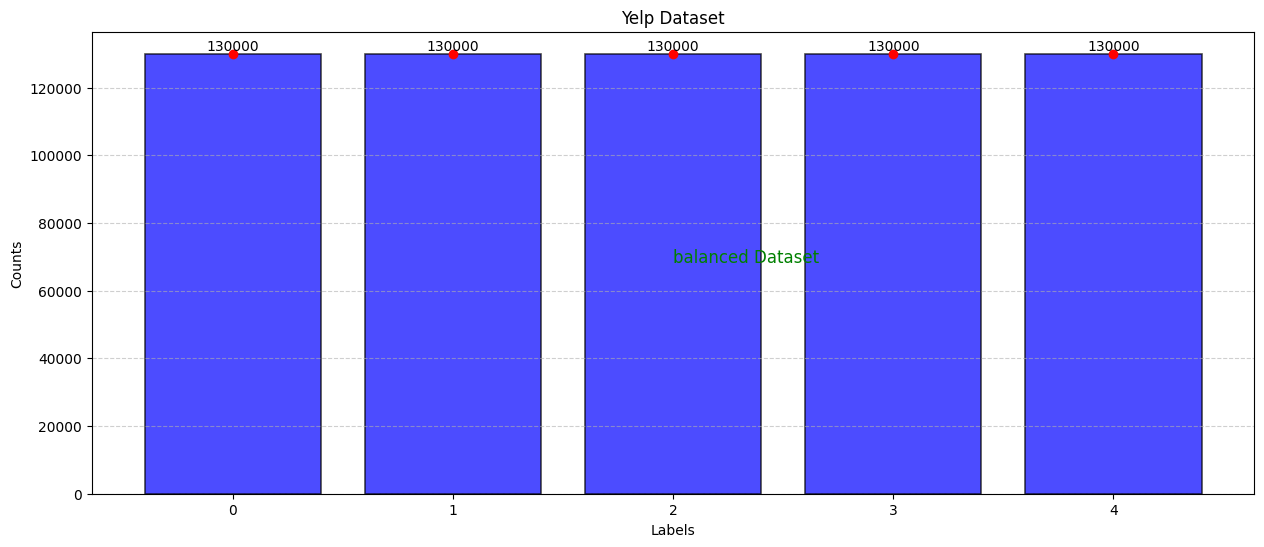

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import json


plt.figure(figsize=(15, 6))
_, labels,_ = yelp_data
label_counts = Counter(labels.numpy())
bars = plt.bar(label_counts.keys(), label_counts.values(),
        color='b',
        alpha=0.7,
        align='center',
        edgecolor='black',
        linewidth=1.2)

plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.annotate('balanced Dataset',
             xy=(0.5, 0.5), xytext=(0.5, 0.5), 
             textcoords='axes fraction', fontsize=12, 
             color='g')

plt.scatter(label_counts.keys(),
            label_counts.values(), 
            color='red')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height,
             f'{int(height)}', ha='center', va='bottom')

plt.title('Yelp Dataset')
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.xticks(ticks=np.arange(5),)
plt.show()



In [4]:
goemotions_pytorch = GoEmotionsDataset(split="train")
ge_dataloaders = torch.utils.data.DataLoader(goemotions_pytorch, batch_size=len(goemotions_pytorch), shuffle=False)
goemotions_data = next(iter(ge_dataloaders))


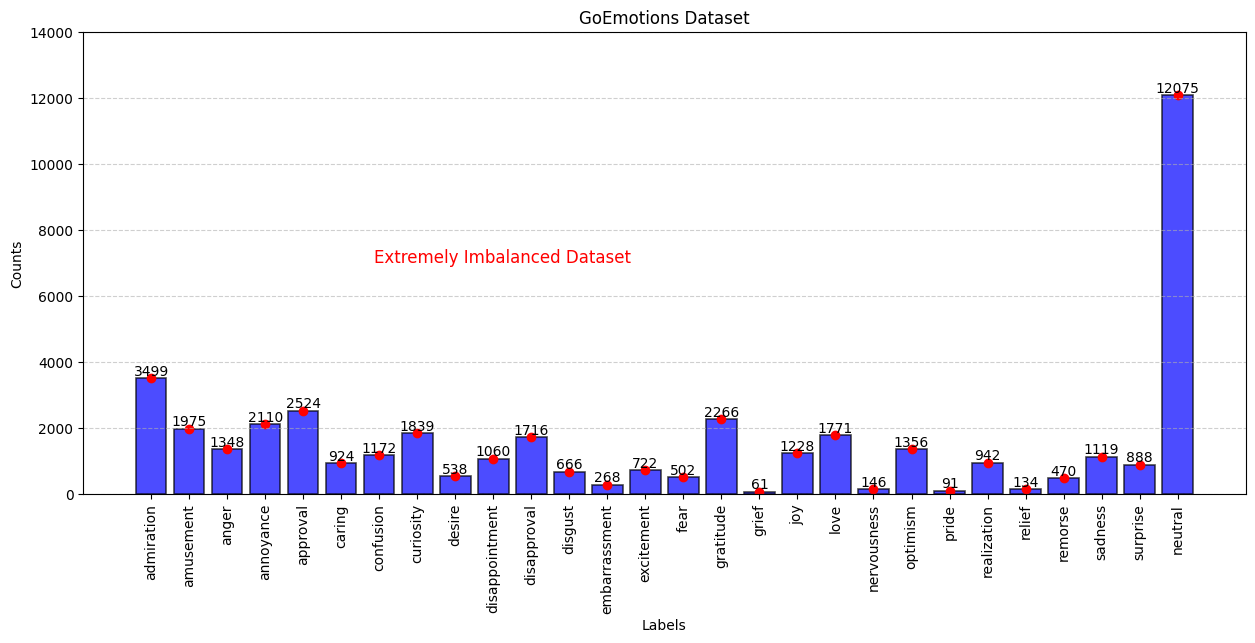

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import json

with open('data/goemotions_labels.json') as f:
    label_names = json.load(f)['names']

_ , labels , _ = goemotions_data
label_counts = Counter(labels.numpy())

plt.figure(figsize=(15, 6))
bars = plt.bar(label_counts.keys(), label_counts.values(),
        color='b',
        alpha=0.7,
        align='center',
        edgecolor='black',
        linewidth=1.2)

plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.annotate('Extremely Imbalanced Dataset',
             xy=(0.5, 0.5), xytext=(0.25, 0.5), 
             textcoords='axes fraction', fontsize=12, 
             color='red')

plt.scatter(label_counts.keys(),
            label_counts.values(), 
            color='red')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height,
             f'{int(height)}', ha='center', va='bottom')

plt.title('GoEmotions Dataset')
plt.xlabel('Labels')
plt.ylabel('Counts')
plt.ylim(0, 14000)
plt.xticks(ticks=np.arange(len(label_names)), labels=label_names, rotation=90)
plt.show()


#### MODEL ON YELP

In [21]:
classifier = torch.load("final_models/best_eval_epoch__192299_model_dict_yelp_lstm_model.pt", 
                        map_location=torch.device('cpu'))
config = classifier['model_config']
yelp_trans_model = LSTMClassifier(**config)
yelp_trans_model.load_state_dict(classifier['model'])

<All keys matched successfully>

In [24]:
yelp_test = YelpDataset(split="test")
dataloaders = torch.utils.data.DataLoader(yelp_test, batch_size=500, shuffle=True)
model = yelp_trans_model
model.eval()
test_loss = 0
correct_predictions = 0
total_predictions = 0
model_outputs = []
for input, labels, masks in tqdm(dataloaders):
    output = model(input)
    for outputi in output:
        model_outputs.append(F.softmax(outputi, dim=0).detach().numpy())
    correct_predictions += (output.argmax(dim=1) == labels).sum().item()
    total_predictions += labels.size(0)
    break
accuracy = correct_predictions / total_predictions
print(f"{accuracy:0.2f}")


  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

